In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
torch.cuda.empty_cache()

In [4]:
df_bkg = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_background.csv')
df_sig = pd.read_csv('/nfs/dust/cms/user/amohamed/susy-desy/CMGSamples/FR_forMVA_nosplit_resTop/csvs/MultiClass_signal.csv')

df_sig.loc[:,'Y'] = 1
df_bkg.loc[:,'Y'] = 0

In [5]:
_df_all = pd.DataFrame()
_df_all = pd.concat([df_sig,df_bkg],sort=False)
del df_sig; del df_bkg
print (_df_all.groupby(['Y']).size())


Y
0    1512085
1     472853
dtype: int64


In [6]:
class Classifier(nn.Module):
    
    def __init__(self, width, n_inputs=2):
        super(Classifier, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(n_inputs, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = torch.sigmoid(self.output(x))
    
        return x

In [7]:
class Regressor(nn.Module):
    
    def __init__(self, width):
        super(Regressor, self).__init__()
        self.width = width
    
        # input layer
        self.input = nn.Linear(1, width)
    
        # hidden layers
        self.h1 = nn.Linear(width, width)
        self.h2 = nn.Linear(width, width)
    
        # output layer
        self.output = nn.Linear(width, 1)

    def forward(self, x):
    
        # input layer
        x = F.relu(self.input(x))
    
        # hidden layers
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        
        # output layer
        x = self.output(x)
    
        return x

In [8]:
from tqdm import tqdm_notebook as tqdm
def normal_training(n_inputs,epochs=200, nbatch = 291):

    # create the classifier and the adversary networks
    clf = Classifier(128, n_inputs=n_inputs).to(device)

    # training settings
    learning_rate = 0.001

    # choose the criterions
    clf_criterion = nn.BCELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)

    # keep track of the losses
    clf_losses = []
    clf_losses_test = []
    
    clf_avg_losses = []
    clf_avg_losses_test = []
    
    # training loop
    for i in tqdm(range(epochs)):
        for j in tqdm(range(nbatch)):
            # create the data
            indx = torch.randint(0, X_train.shape[0], size=(4096, ))
            #X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
            X, Y, Z = X_train[indx], Y_train[indx], Z_train[indx]
            X = torch.as_tensor(X, dtype=torch.float).to(device)
            Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float).to(device)
            Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float).to(device)

        # make the training loss
            clf_output = clf(X)
            clf_loss = clf_criterion(clf_output, Y)

        # backprop
            clf.zero_grad()
            clf_loss.backward()
            clf_optimiser.step()            

            clf_losses.append(clf_loss.to('cpu').detach().numpy())

            
            indx = torch.randint(0, X_test.shape[0], size=(1500, ))
            X_t, Y_t = X_test[indx], Y_test[indx]
            X_t = torch.as_tensor(X_t, dtype=torch.float).to(device)
            Y_t = torch.as_tensor(Y_t.reshape(-1, 1), dtype=torch.float).to(device)
            output_test = clf(X_t)
            loss_test = clf_criterion(output_test, Y_t)
            
            clf_losses_test.append(loss_test.to('cpu').detach().numpy())
    
    
        # calculate averages and use them in plots
        clf_avg_losses.append(np.mean(clf_losses)) 
        clf_avg_losses_test.append(np.mean(clf_losses_test))
    
    
    print('Done with training')

    fig, ax = plt.subplots()
    ax.plot(range(len(clf_avg_losses)), clf_avg_losses, label='train loss')
    ax.plot(range(len(clf_avg_losses_test)), clf_avg_losses_test, label='test loss')
    ax.set_xlabel('Training step')
    ax.set_ylabel('Classifier loss')
    ax.legend(loc='best')
    plt.show()
    
    return clf

In [94]:
from tqdm import tqdm_notebook as tqdm
def adversarial_training(n_inputs,epochs=200, nbatch = 291):
    
    # create the classifier and the adversary networks
    clf = Classifier(128, n_inputs=n_inputs).to(device)
    adv = Regressor(50).to(device)

    # training settings
    learning_rate = 0.001
    lam = 10 # lambda tradeoff parameter

    # choose the criterions
    clf_criterion = nn.BCELoss()
    adv_criterion = nn.MSELoss()

    # create optimisers (larger learning rate for the adversary )
    clf_optimiser = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    adv_optimiser = torch.optim.Adam(adv.parameters(), lr=5*learning_rate)

    # keep track of the losses
    clf_losses = []
    adv_losses = []
    clf_losses_test = []
    adv_losses_test = []
    
    clf_avg_losses = []
    clf_avg_losses_test = []
    adv_avg_losses = []
    
    # training loop
    for i in tqdm(range(epochs)):
        for j in tqdm(range(nbatch)):
            # create the data
            indx = torch.randint(0, X_train.shape[0], size=(4096, ))
            #X_batch, y_batch, z_batch = X_train[indx], y_train[indx], z_train[indx]
            X, Y, Z = X_train[indx], Y_train[indx], Z_train[indx]
            X = torch.as_tensor(X, dtype=torch.float).to(device)
            Y = torch.as_tensor(Y.reshape(-1, 1), dtype=torch.float).to(device)
            Z = torch.as_tensor(Z.reshape(-1, 1), dtype=torch.float).to(device)

            ##############################
            # Update the adversary network
            # (several updtes to keep up with
            # the changes in the classifier)
            ##############################

            M = 5
            for _ in range(M):
                # make the adversary loss
                clf_output = clf(X)
                adv_output = adv(clf_output)
                adv_loss = adv_criterion(adv_output, Z)

                # backprop: adapt the adversary to the classifier (only update the adversary weights)
                adv.zero_grad()
                adv_loss.backward()
                adv_optimiser.step()

            adv_losses.append(adv_loss.to('cpu').detach().numpy())

            ##############################
            # Update the classifier network
            ##############################

            # forward pass
            clf_output = clf(X)
            adv_output = adv(clf_output)

            # make the losses: both the classifier and the adversary loss
            # combined loss: note the minus sign!
            # (when updating the classifier, the goal is to confuse the adversary)
            clf_loss = clf_criterion(clf_output, Y)
            adv_loss = adv_criterion(adv_output, Z)
            comb_loss = clf_loss - lam * adv_loss

            # backprop the classifier: update only the classifier weights (keep adversary intact)
            clf.zero_grad()
            comb_loss.backward()
            clf_optimiser.step()

            clf_losses.append(clf_loss.to('cpu').detach().numpy())

        #Make loss
            indx = torch.randint(0, X_test.shape[0], size=(1500, ))
            X_t, Y_t = X_test[indx], Y_test[indx]
            X_t = torch.as_tensor(X_t, dtype=torch.float).to(device)
            Y_t = torch.as_tensor(Y_t.reshape(-1, 1), dtype=torch.float).to(device)
            output_test = clf(X_t)
            loss_test = clf_criterion(output_test, Y_t)
            
            clf_losses_test.append(loss_test.to('cpu').detach().numpy())
    
        
        # calculate averages and use them in plots
        clf_avg_losses.append(np.mean(clf_losses)) 
        clf_avg_losses_test.append(np.mean(clf_losses_test))
        adv_avg_losses.append(np.mean(adv_losses))
        
    
    print('Done with training')

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(range(len(clf_avg_losses)), clf_avg_losses, label='train loss')
    ax[0].plot(range(len(clf_avg_losses_test)), clf_avg_losses_test, label='test loss')
    ax[0].set_ylabel('Classifier loss')
    ax[0].legend(loc='best')
    ax[1].plot(range(len(adv_avg_losses)), adv_avg_losses, color='k')
    ax[1].set_ylabel('Adversary loss')
    ax[1].set_xlabel('Training step')
    plt.show()
    
    return clf

In [10]:
###This block is dedicated to creating plots to evaluate the training of the NN

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve


def show_roc_curves(Y0, Y0_pred, Y1, Y1_pred, ax, clf):    
    
    # compute the roc curves
    fpr0, tpr0, _ = roc_curve(Y0, Y0_pred.cpu().detach().numpy())
    roc_auc0 = metrics.auc(fpr0, tpr0)

    fpr1, tpr1, _ = roc_curve(Y1, Y1_pred.cpu().detach().numpy())
    roc_auc1 = metrics.auc(fpr1, tpr1)

    # draw the roc curves
    ax.plot(fpr0, tpr0, c='k', label='0 <dPhi< 1,   AUC = %0.2f' % roc_auc0)
    ax.plot(fpr1, tpr1, c='red', label='1 <dPhi < 3.14,   AUC = %0.2f' % roc_auc1)

    # cosmetics
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    
    
def show_clf_output(Y0_pred, Y1_pred, ax, clf):

    # show them... density=True normalizes them
    bins = 30
    ax.hist(Y0_pred.cpu().detach().numpy(), bins=bins, density=True, color='k', histtype='step', label='0 <dPhi< 1 ')
    ax.hist(Y1_pred.cpu().detach().numpy(), bins=bins, density=True, color='red', histtype='step', label='1 <dPhi< 3.14')   
    
    ax.set_yscale('log')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output')
    ax.set_xlabel('Classifier output')
    

def show_clf_output_weight(Y0_pred, FW0, Y1_pred, FW1, ax, clf):
   
    # show them... density=True normalizes them
    bins = 30
    ax.hist(Y0_pred.cpu().detach().numpy(), bins=bins, density=True, weights=FW0, color='k', histtype='step', label='0 <dPhi< 1 ')
    ax.hist(Y1_pred.cpu().detach().numpy(), bins=bins, density=True, weights=FW1, color='red', histtype='step', label='1 <dPhi< 3.14')   
    
    ax.set_yscale('log')

    # cosmetics
    ax.legend(loc='best')
    ax.set_title('Classifier output (with weighted bkg events)')
    ax.set_xlabel('Classifier output')
    
def evaluate_hbb_classifier(clf):

    #Get test data
    X0, Y0, Z0, FW0 = testFW(0, 1)
    X1, Y1, Z1, FW1 = testFW(1, 3.14)
    
    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float).to(device))
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    show_roc_curves(Y0, Y0_pred, Y1, Y1_pred, ax[0], clf)
    show_clf_output(Y0_pred, Y1_pred, ax[1], clf)
    
    
    # Get Bkg test data for the weighted curve
    X0, Y0, Z0, FW0 = testBkgFW(0, 1)
    X1, Y1, Z1, FW1 = testBkgFW(1, 3.14)
    
    # compute the predictions
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))
    Y1_pred = clf(torch.as_tensor(X1, dtype=torch.float).to(device))
    
    show_clf_output_weight(Y0_pred, FW0, Y1_pred, FW1, ax[2], clf)
    plt.show()
    

In [11]:
#~~~ 4 Useful functions

## (1) Function that returns only Bkg Test data X,Y,Z + FW in a range

def testBkgFW(zmin, zmax):
    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([S_test, Q_test, R_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    sss=ss[(ss.Y==0)]
    
    #Deconcatenate s
    FW=sss.loc[:,['Finalweight']]
    X_full=sss.drop(['Finalweight'], axis=1)

    Z_full=X_full.loc[:,['dPhi']]
    X_full=X_full.drop(['dPhi'], axis=1)
                   
    Y_full=X_full.loc[:, ['Y']]          
    X_full=X_full.drop(['Y'], axis=1)
            
    return X_full.values, Y_full.values, Z_full.values, FW.values


## (2) Function that returns all Test data X,Y,Z + FW in a range

def testFW(zmin, zmax):
    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([S_test, Q_test, R_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.dPhi > zmin) & (s.dPhi < zmax)]
    
    #Deconcatenate s
    FW=ss.loc[:,['Finalweight']]
    X_full=ss.drop(['Finalweight'], axis=1)

    Z_full=X_full.loc[:,['dPhi']]
    X_full=X_full.drop(['dPhi'], axis=1)
                   
    Y_full=X_full.loc[:, ['Y']]          
    X_full=X_full.drop(['Y'], axis=1)
            
    return X_full.values, Y_full.values, Z_full.values, FW.values


## (3) Function that returns all Bkg Test data X,Y,Z + FW over all ranges

def testBkg():
    
    #Concatenate all --> try to remove rows of dPhi out of range --> Deconcatenate
    s=pd.concat([S_test, Q_test, R_test], axis = 1)
    
    # Keep only rows which satisfy these conditions
    ss=s[(s.Y==0)]
    
    #Deconcatenate s
    FW=ss.loc[:,['Finalweight']]
    X_full=ss.drop(['Finalweight'], axis=1)

    Z_full=X_full.loc[:,['dPhi']]
    X_full=X_full.drop(['dPhi'], axis=1)
                   
    Y_full=X_full.loc[:, ['Y']]          
    X_full=X_full.drop(['Y'], axis=1)
            
    return X_full.values, Y_full.values, Z_full.values, FW.values


# (4) Function that calculates and prints the ratio

def ratio (clf):

    X0, Y0, Z0, FW0 = testBkg()
    Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))
    
    C=Y0_pred.cpu().detach().numpy()    
        
    dl=0; ul=0; dr=0; ur=0

    for i in range(Y0.size):
        if (C[i]<0.5 and Z0[i]<1.57):
            dl=dl+1*FW0[i]
                    
        if (C[i]>0.5 and Z0[i]<1.57):
            dr=dr+1*FW0[i]          
                                
        if (C[i]<0.5 and Z0[i]>1.57):
            ul=ul+1*FW0[i]
    
        if (C[i]>0.5 and Z0[i]>1.57):
            ur=ur+1*FW0[i]
    
    print("Classifier Output:")
    print("A =", ul)
    print("B =", dl)
    print("C =", dr)
    print("D =", ur)

    print("Ratio =", (ul/dl)/(ur/dr))


In [12]:
    ## Density plot functions
    
    # (1) Scatter w/o weighting
    
def scatter(clf):
    
        X0, Y0, Z0, FW0 = testBkgFW(0, 3.14)
        Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))   ####This is the classifier output

        C= Y0_pred.cpu().detach().numpy()  
        
        fig = plt.figure()
        fig, ax = plt.subplots(1, figsize=(10, 5))
        plt.scatter(C,Z0, marker='.')
        fig.suptitle('Correlation', fontsize=20)

        plt.xlabel('adv output', fontsize=18)
        plt.ylabel('dPhi', fontsize=16)
        plt.show()
        

    
    # (2) Density with weighting & logarithmic

def density(clf):
    
        X0, Y0, Z0, FW0 = testBkgFW(0, 3.14)
        Y0_pred = clf(torch.as_tensor(X0, dtype=torch.float).to(device))   ####This is the classifier output
       
        C= Y0_pred.cpu().detach().numpy()  
        
        fig = plt.figure()
        fig, ax = plt.subplots(1, figsize=(10, 5))
        plt.hist2d(C.reshape(-1), Z0.reshape(-1), bins=500, weights=FW0.reshape(-1), norm=mpl.colors.LogNorm())
        fig.suptitle('Correlation', fontsize=20)

        plt.xlabel('clf output', fontsize=18)
        plt.ylabel('dPhi', fontsize=16)
        plt.show()

In [95]:
    # Train-Test-Split

train_DF, test_DF = train_test_split(_df_all, train_size=0.6, test_size=0.4, shuffle=True, random_state=0)
features = ['MET', 'MT', 'Jet2_pt','Jet1_pt', 'nLep', 'Lep_pt', 'Selected', 'nVeto', 'LT', 'HT', 'nBCleaned_TOTAL','nTop_Total_Combined', 'nJets30Clean',"Lep_relIso","Lep_miniIso","iso_pt","iso_MT2", "Finalweight"]

S_train= train_DF[features].copy()
S_test= test_DF[features].copy()

P_train = train_DF[features].drop(['Finalweight'], axis=1).copy()
P_test  = test_DF[features].drop(['Finalweight'], axis=1).copy()
Q_train = train_DF['Y'].copy()
Q_test  = test_DF['Y'].copy()
R_train = train_DF['dPhi'].copy()
R_test  = test_DF['dPhi'].copy()

del train_DF ; del test_DF

In [96]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = [
    torch.tensor(x).to(device)
    for x in [P_train.values, P_test.values, Q_train.values, Q_test.values, R_train.values, R_test.values]
]


Done with training


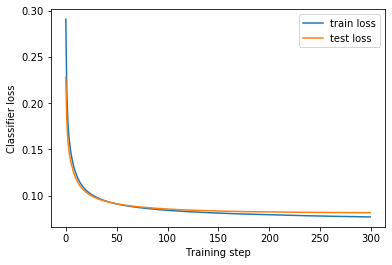

In [90]:

clf = normal_training(X_train.shape[1], epochs=300)


Done with training


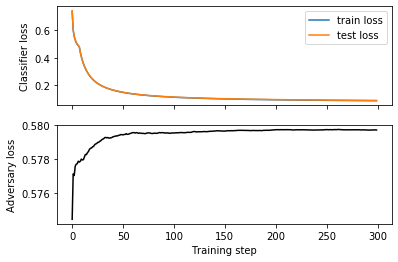

In [97]:
adv = adversarial_training(X_train.shape[1], epochs=300)

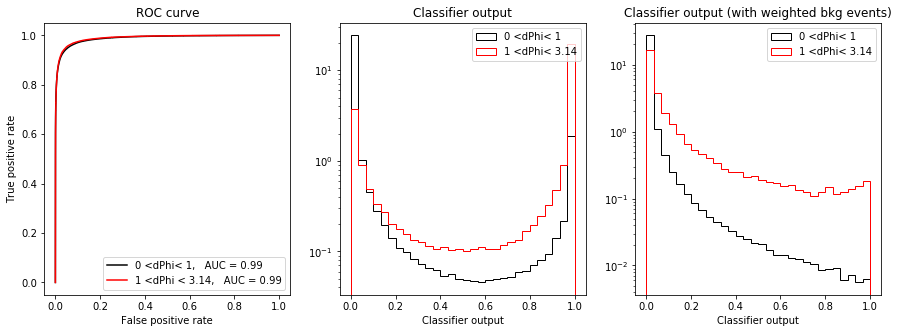

In [98]:
evaluate_hbb_classifier(adv)

In [99]:
ratio(adv)

Classifier Output:
A = [0.12198268]
B = [4.92207056]
C = [0.03254026]
D = [0.01245933]
Ratio = [0.06472567]


<Figure size 432x288 with 0 Axes>

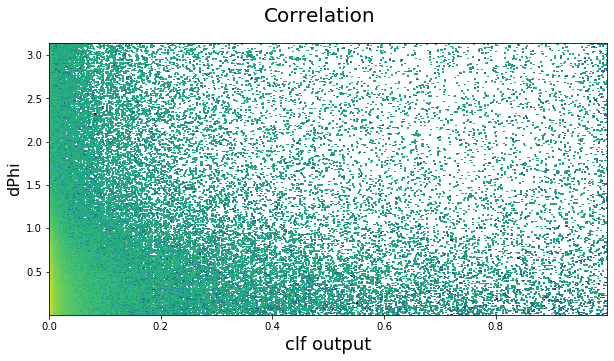

In [100]:
density(adv)